In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.models import Model

Using TensorFlow backend.


### Loading the Data

In [2]:
from keras.datasets import mnist

(train_data, _), (test_data, _) = mnist.load_data() # We do not load the labels. We want to reconstruct the images as output of the autoencoder.

In [3]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape = train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape = test_data.shape))

Training set (images) shape: (60000, 28, 28)
Test set (images) shape: (10000, 28, 28)


### Data Preprocessing

In [4]:
# Creating a training set and test set and normalizing the data to train the model better.
train_data = train_data.astype('float32')/np.max(train_data)
test_data = test_data.astype('float32')/np.max(test_data)

In [5]:
train_data = train_data.reshape(-1, 28,28, 1)
test_data = test_data.reshape(-1, 28,28, 1)

train_data.shape, test_data.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [6]:
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [7]:
# Verify the maximum value of training and testing data which should be 1.0 after rescaling it
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [8]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                             train_data, 
                                                             test_size=0.2, 
                                                             random_state=13)

### Convolutional Autoencoder

In [9]:
batch_size = 128
epochs = 10
channel = 1
x, y = 28, 28

In [10]:
# input = 28 x 28 x 1
input = Input(shape=(x, y, channel), name='input') 

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1')(input) #28 x 28 x 32
x = BatchNormalization()(x) #28 x 28 x 32
x = MaxPooling2D(pool_size=(2, 2))(x) #14 x 14 x 32
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2')(x) #14 x 14 x 64
x = BatchNormalization()(x) #14 x 14 x 64
x = MaxPooling2D(pool_size=(2, 2))(x) #7 x 7 x 64
encoded = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3')(x) #7 x 7 x 128 

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4')(encoded) #7 x 7 x 128
x = BatchNormalization()(x) #7 x 7 x 128
x = UpSampling2D((2,2))(x) # 14 x 14 x 128
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_5')(x) #14 x 14 x 64
x = BatchNormalization()(x) #14 x 14 x 64
x = UpSampling2D((2,2))(x) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output')(x) #28 x 28 x 1

autoencoder = Model(inputs=input, outputs=decoded, name='CAE')
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

In [11]:
autoencoder.summary()

Model: "CAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 28, 28, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 14, 14, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0       

### Train the model

In [12]:
autoencoder_train = autoencoder.fit(train_X, 
                                    train_ground, 
                                    batch_size = batch_size,
                                    epochs = epochs,
                                    verbose = 1,
                                    validation_data = (valid_X, valid_ground))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 821s 17ms/step - loss: 0.1453 - val_loss: 0.1603
Epoch 2/10
48000/48000 [==============================] - 374s 8ms/step - loss: 0.0748 - val_loss: 0.0754
Epoch 3/10
48000/48000 [==============================] - 372s 8ms/step - loss: 0.0717 - val_loss: 0.0703
Epoch 4/10
48000/48000 [==============================] - 522s 11ms/step - loss: 0.0700 - val_loss: 0.0726
Epoch 5/10
48000/48000 [==============================] - 722s 15ms/step - loss: 0.0692 - val_loss: 0.0707
Epoch 6/10
48000/48000 [==============================] - 574s 12ms/step - loss: 0.0684 - val_loss: 0.0676
Epoch 7/10
48000/48000 [==============================] - 590s 12ms/step - loss: 0.0679 - val_loss: 0.0686
Epoch 8/10
48000/48000 [==============================] - 376s 8ms/step - loss: 0.0673 - val_loss: 0.0682
Epoch 9/10
48000/48000 [==============================] - 363s 8ms/step - loss: 0.0670 - val_loss

### Training vs Validation Loss Plot

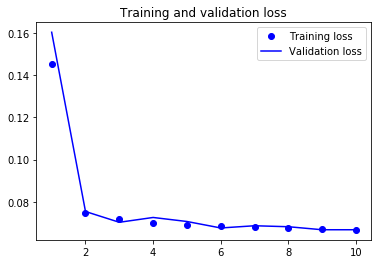

In [13]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1, epochs+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicting on Test Data

In [14]:
predicted = autoencoder.predict(test_data)

In [15]:
predicted.shape

(10000, 28, 28, 1)

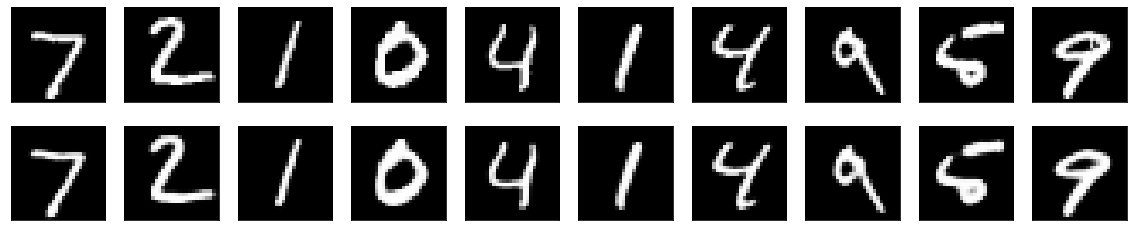

In [16]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original test images
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
   
    # Display reconstructed images
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()

### Denoising Autoencoder

In [17]:
noise_factor = 0.5

# Add random noise to the input images
x_train_noisy = train_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=train_X.shape)
x_valid_noisy = valid_X + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=valid_X.shape)
x_test_noisy = test_data + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=test_data.shape)

# Clip the images to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_valid_noisy = np.clip(x_valid_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

### Visualizing the noisy images

([], <a list of 0 Text yticklabel objects>)

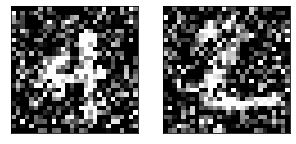

In [18]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
img = np.reshape(x_train_noisy[1], (28,28))
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])

# Display the first image in testing data
plt.subplot(122)
img = np.reshape(x_test_noisy[1], (28,28))
plt.imshow(img, cmap='gray')
plt.xticks([])
plt.yticks([])

### Denoising Autoencoder Network

In [19]:
batch_size = 128
epochs = 10
channel = 1
x, y = 28, 28

In [20]:
# input = 28 x 28 x 1
input = Input(shape=(x, y, channel), name='input') 

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1')(input) #28 x 28 x 32
x = BatchNormalization()(x) #28 x 28 x 32
x = MaxPooling2D(pool_size=(2, 2))(x) #14 x 14 x 32
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2')(x) #14 x 14 x 64
x = BatchNormalization()(x) #14 x 14 x 64
x = MaxPooling2D(pool_size=(2, 2))(x) #7 x 7 x 64
encoded = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3')(x) #7 x 7 x 128 

# Decoder
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4')(encoded) #7 x 7 x 128
x = BatchNormalization()(x) #7 x 7 x 128
x = UpSampling2D((2,2))(x) # 14 x 14 x 128
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_5')(x) #14 x 14 x 64
x = BatchNormalization()(x) #14 x 14 x 64
x = UpSampling2D((2,2))(x) # 28 x 28 x 64
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same', name='output')(x) #28 x 28 x 1

autoencoder = Model(inputs=input, outputs=decoded, name='CAE')
autoencoder.compile(loss='binary_crossentropy', optimizer='adadelta')

### Training

In [21]:
autoencoder_train = autoencoder.fit(x_train_noisy, 
                                    train_X, 
                                    batch_size=batch_size,
                                    epochs=epochs,
                                    verbose=1,
                                    validation_data=(x_valid_noisy, valid_X))

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 546s 11ms/step - loss: 0.1630 - val_loss: 0.3554
Epoch 2/10
48000/48000 [==============================] - 558s 12ms/step - loss: 0.1035 - val_loss: 0.1011
Epoch 3/10
48000/48000 [==============================] - 428s 9ms/step - loss: 0.1005 - val_loss: 0.0999
Epoch 4/10
48000/48000 [==============================] - 321s 7ms/step - loss: 0.0988 - val_loss: 0.0982
Epoch 5/10
48000/48000 [==============================] - 344s 7ms/step - loss: 0.0973 - val_loss: 0.0967
Epoch 6/10
48000/48000 [==============================] - 437s 9ms/step - loss: 0.0966 - val_loss: 0.0988
Epoch 7/10
48000/48000 [==============================] - 336s 7ms/step - loss: 0.0959 - val_loss: 0.0976
Epoch 8/10
48000/48000 [==============================] - 356s 7ms/step - loss: 0.0952 - val_loss: 0.0957
Epoch 9/10
48000/48000 [==============================] - 348s 7ms/step - loss: 0.0947 - val_loss: 0

### Train versus Validation Loss Plot

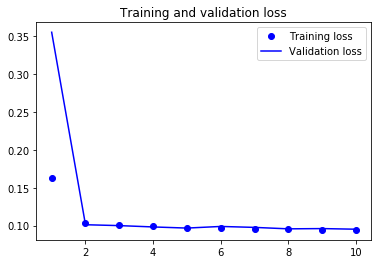

In [22]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(1, epochs+1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Predicting on Test dataset

In [23]:
predicted = autoencoder.predict(x_test_noisy)

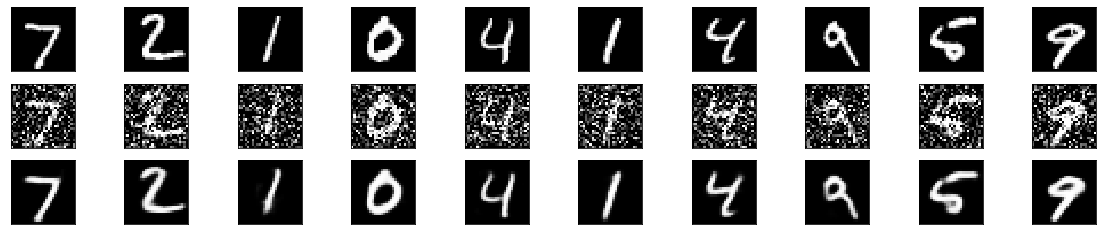

In [24]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original test images
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(test_data[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # Display Test Images with Noise
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
   
    # Display reconstructed noisy images
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(predicted[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  
    
plt.show()